In [1]:
pip install lime

     |████████████████████████████████| 276kB 7.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=8b8f8b32a7d44ecccf831d1523147aad208e5c594e8d53eb0a6c95ed32a194b7
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


# Une procédure complète de Machine Learning en Python: troisième partie

Pour rappel, nous travaillons sur un problème d'apprentissage automatique de régression supervisée. En utilisant *les données énergétiques des bâtiments de la ville de New York* , nous avons développé un modèle qui peut prédire le score Energy Star d'un bâtiment. Le modèle final que nous avons construit est un *Gradient Boosted Regressor* qui est capable de prédire le score Energy Star sur les données de test à 6,1 points près (sur une échelle de 1 à 100).

### Interprétation du modèle
Le régresseur boosté par gradient se situe quelque part au milieu de l' échelle d'interprétabilité du modèle : le modèle entier est complexe, mais il est composé de centaines d' arbres de décision , qui sont en eux-mêmes assez compréhensibles.Nous examinerons trois façons de comprendre comment notre modèle fait des prédictions:

1. Importances des fonctionnalités  
2. Visualiser un arbre de décision unique  
3. LIME: Explications locales interprétables indépendantes du modèle

Les deux premières méthodes sont spécifiques aux ensembles d'arbres, tandis que la troisième - comme vous l'avez peut-être deviné à partir de son nom - peut être appliquée à n'importe quel modèle d'apprentissage automatique. LIME est un package relativement nouveau et représente une étape passionnante dans l'effort continu pour expliquer les prédictions d'apprentissage automatique .

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import  MinMaxScaler  #Imputer,
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree

# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [3]:
# Read in data into dataframes
#train_features = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/training_features.csv')
#test_features = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/testing_features.csv')
#train_labels = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/training_labels.csv')
#test_labels = pd.read_csv('C:/Users/Sony/Desktop/Mes_Docs/DA_DS/testing_labels.csv')


train_features =  pd.read_csv("/content/training_features.csv")
test_features = pd.read_csv("/content/testing_features.csv")
train_labels = pd.read_csv("/content/training_labels.csv")
test_labels = pd.read_csv("/content/testing_labels.csv")



**Recreate Final Model**

In [4]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [5]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [6]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 22.8867


#### Importance des features

L'importance des fonctionnalités tente de montrer la pertinence de chaque fonctionnalité pour la tâche de prédiction de la cible. Les détails techniques de l'importance des caractéristiques sont complexes (ils mesurent la diminution moyenne d'impureté ou la réduction de l'erreur due à l'inclusion de la caractéristique ), mais nous pouvons utiliser les valeurs relatives pour comparer les caractéristiques les plus pertinentes. Dans Scikit-Learn, nous pouvons extraire les importances des fonctionnalités de n'importe quel ensemble d'apprenants arborescents.

Avec `model` comme modèle entraîné, nous pouvons trouver les importances des fonctionnalités en utilisant `model.feature_importances_` . Ensuite, nous pouvons les mettre dans un DataFrame pandas et afficher ou tracer les dix premiers plus importants:

In [8]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature':list(train_features.columns),
                               'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

feature  importance
0                                              Order    0.163209
1                                          log_Order    0.148361
2                 Property GFA - Self-Reported (ft²)    0.111122
3             log_Property GFA - Self-Reported (ft²)    0.101914
4  log_Largest Property Use Type - Gross Floor Ar...    0.101172
5  Largest Property Use Type - Gross Floor Area (...    0.095403
6                                     log_Year Built    0.088480
7                                         Year Built    0.083425
8                   Largest Property Use Type_Office    0.044321
9      Largest Property Use Type_Multifamily Housing    0.011945

The Site Energy Use Intensity, Order, and the log_Order are the two most important features by quite a large margin. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

Let's graph the feature importances to compare visually.

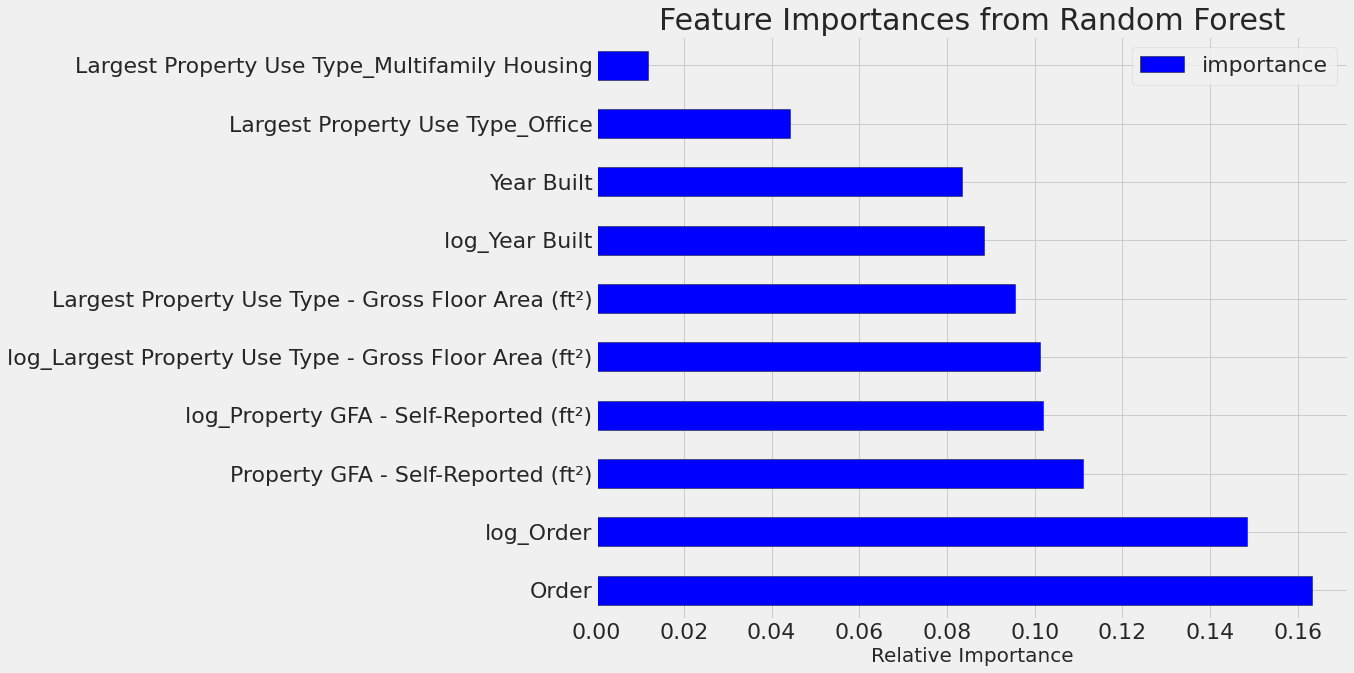

In [9]:
figsize(12,10)
plt.style.use('fivethirtyeight')

# plot the 10 most important features in a horizontal barchart
feature_results.loc[:9, :].plot(x='feature', y='importance',
                               edgecolor='k', kind='barh', color = 'blue')
plt.xlabel('Relative Importance', size = 20)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size=30)
plt.show()

#### **Use Feature Importances for Feature Selection**  
  
  Given that not every feature is important for finding the score, what would happen if we used a simpler model, such as a linear regression, with the subset of most important features from the random forest ? The linear regression did outperform the baseline, but it did not perform well compared to the model complex models. Let's try using only the 10 most important features in the linear regression to see if performance is improved. We can also limit to these features and re-evaluate the random forest.

In [10]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that correspond to each featuere name  
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features  
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training feaatures shape:', X_reduced.shape)
print('Monst important testing fetures shape:', X_test_reduced.shape)

Most important training feaatures shape: (6748, 10)
Monst important testing fetures shape: (2893, 10)


In [11]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X,y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE= %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE=%0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE= 24.7931.
Linear Regression Reduced Results: MAE=24.9508.


Well, reducing the features did not improve the linear regression results! It turns out that the extra information in the features with low importance do actually improve performance.  
  
  Let's look at using the reduced set of features in the gradient boosted regressor. How is the performance affected ?

In [12]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# fit and test on the readuced set of features 
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE=%0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE=23.1365


The model results are slightly worse with the reduced set of features and we will keep all of the features for the final model. The desire to reduce the number of features is because we are always looking to build the most parsimonious model: that is, the simplest model with adequate performance. A model that uses fewer features will be faster to train and generally easier to interpret. In this case, keeping all of the features is not a major concern because the training time is not significant and we can still make interpretations with many features.
   

#### Locally Interpretable Model-agnostic Explanations  

We will look at using LIME to explain individual predictions made the by the model. LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.  
  
  We will look at trying to explain the predictions on an example the model gets very wrong and an example the model gets correct. We will restrict ourselves to using the reduced set of 10 features to aid interpretability. The model trained on the 10 most important features is slightly less accurate, but we generally have to trade off accuracy for interpretability!

In [13]:
# Find the residuals 
residuals = abs(model_reduced_pred - y_test)

# Exact the worst and best prediction 
wrong  = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [14]:
# Create a lime explainer object 
explainer = lime.lime_tabular.LimeTabularExplainer(training_data=X_reduced,
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 4.6623
Actual Value: 94.0000


Text(0.5, 0, 'Effect on Prediction')

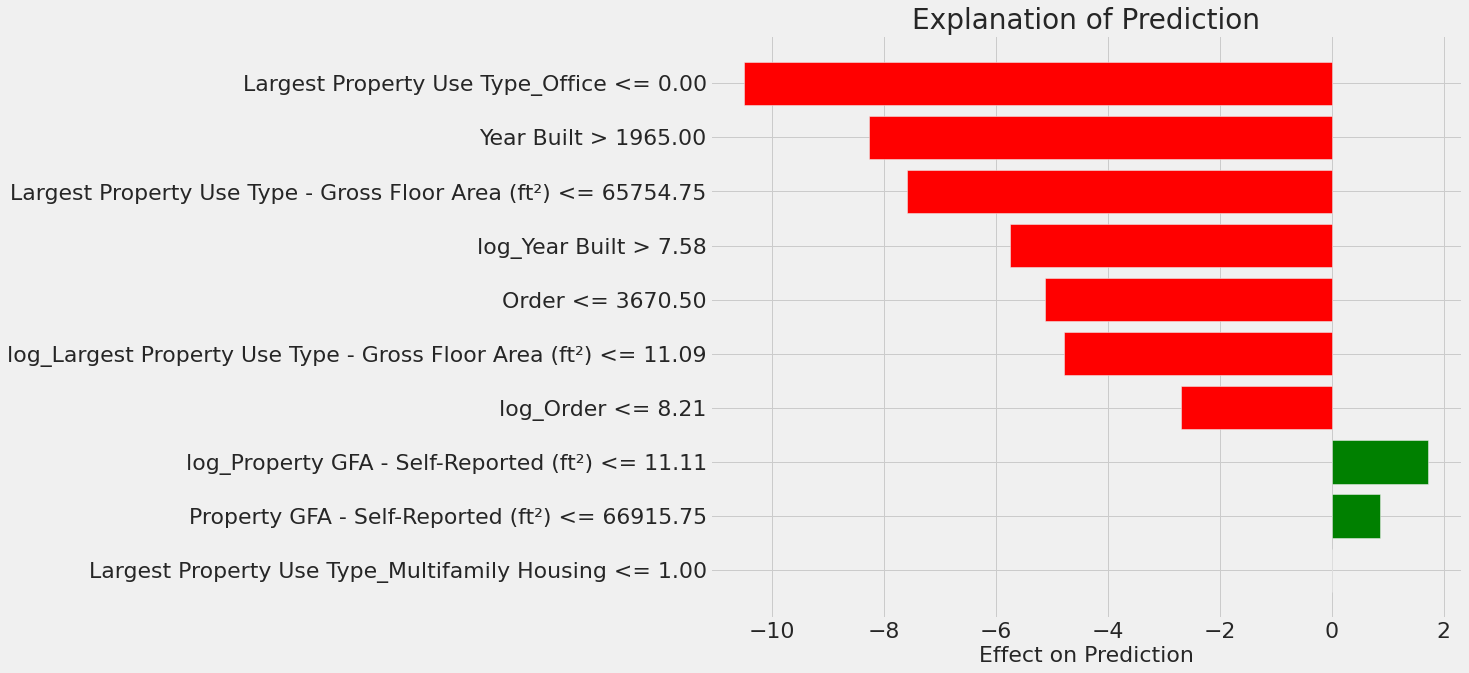

In [15]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])


# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22)

In [16]:
wrong_exp.show_in_notebook(show_predicted_value=False)

In this example, our gradient boosted model predicted a score of 4.6623 and the actual value was 94.00  
  
The plot from LIME is showing us the contribution to the final prediction from each of the features for the example. We can see that the Largest Property Use Type_Office singificantly decreased the prediction because it was above 95.50. The Weather Normalized Site Electricity Intensity on the other hand, increased the prediction because it was lower than 3.80.


Now we can go through the same process with a prediction the model got correct.

Prediction: 99.9979
Actual Value: 100.0000


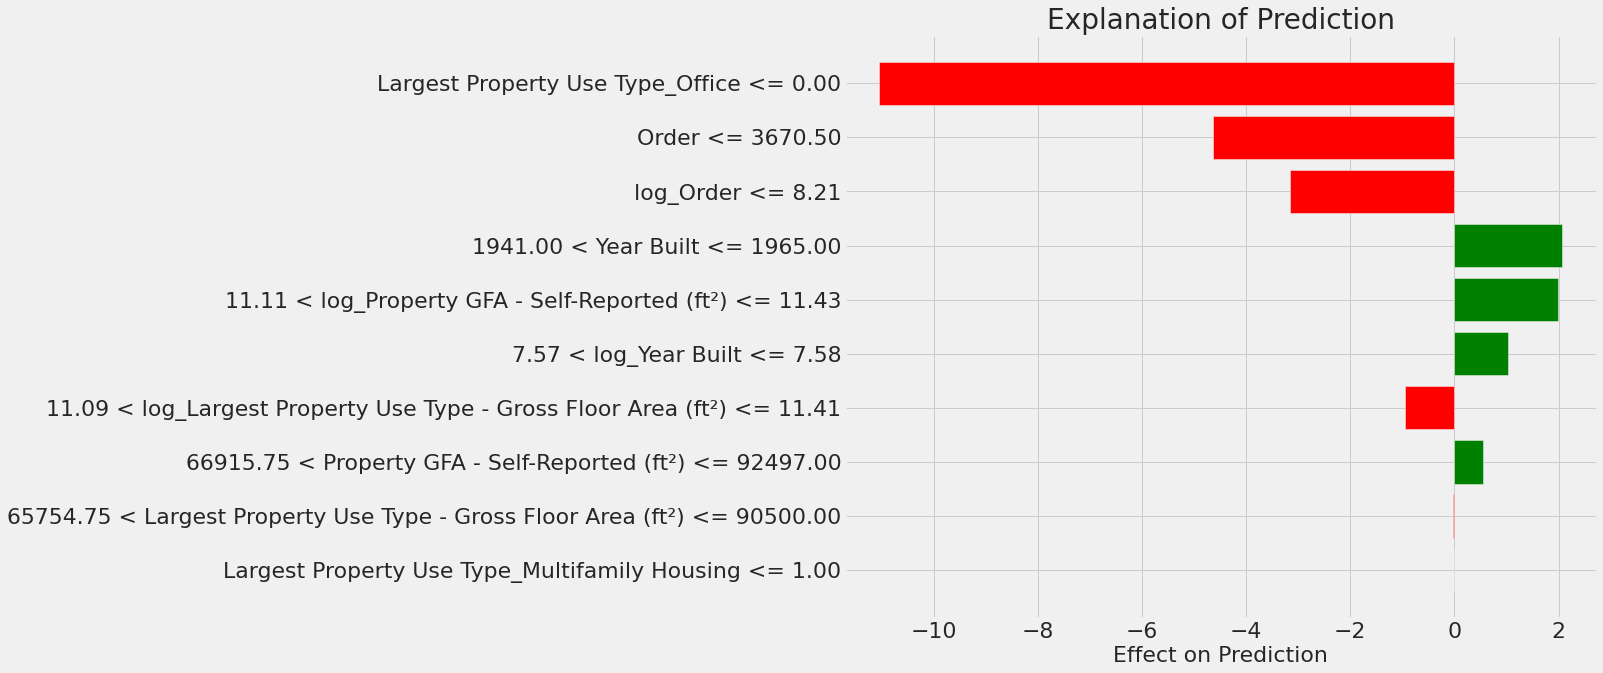

In [17]:
# Display the predicted and true value for the wrong instance

print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [18]:
right_exp.show_in_notebook(show_predicted_value=False)

The correct value for this case was 100 which our gradient boosted model got right on!

Sur la base de ces résultats, nous pouvons enfin répondre à l'une de nos questions initiales: les indicateurs les plus importants du score Energy Star d'un bâtiment sont l'EU du site et l'intensité d'électricité normalisée du site en fonction des conditions météorologiques. Bien que nous voulions faire attention à ne pas trop lire dans les importances des fonctionnalités , elles sont un moyen utile de commencer à comprendre comment le modèle fait ses prédictions.

### ***Visualiser un arbre de décision unique***  
  
Bien que l'ensemble du régresseur d'amplification du gradient puisse être difficile à comprendre, tout arbre de décision individuel est assez intuitif. Nous pouvons visualiser n'importe quel arbre de la forêt en utilisant la fonction `Scikit-Learnexport_graphviz` .  
  
L'une des parties les plus intéressantes d'un methode d'ensemble des arbres est que nous pouvons examiner n'importe quel estimateur individuel. Bien que notre modèle final soit composé de 800 arbres de décision, et en regarder un seul n'est pas indicatif de l'ensemble du modèle, cela nous permet quand même de voir l'idée générale du fonctionnement d'un arbre de décision. À partir de là, il est naturel d'imaginer des centaines de ces arbres en s'appuyant sur les erreurs des arbres précédents pour faire une prédiction finale (il s'agit d'une simplification excessive du fonctionnement de la régression par amplification de gradient!)  
  
Nous allons d'abord extraire un arbre de la forêt, puis l'enregistrer en utilisant `sklearn.tree.export_graphviz.` Cela enregistre l'arbre en tant que fichier .dot qui peut être converti en png en utilisant les instructions de ligne de commande dans le Notebook.


In [29]:
from sklearn import tree

# Extract a single tree (number 105)
single_tree = model.estimators_[105][0]

# Save the tree to a dot file
tree.export_graphviz(single_tree, out_file = 'tree.dot',
                     rounded = True, 
                     filled = True)

single_tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x7F07AA2CDA98,
                      splitter='best')

In [31]:
!dot -Tpng tree.dot -o tree.png

In [35]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot
import pydotplus

dot_data = StringIO()
export_graphviz(single_tree, out_file = dot_data)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png("single.png")
#graph.write_pdf("titan_tree.pdf")

True

Chaque nœud (boîte) de l'arbre contient quatre informations:  
  
  1. La question posée sur la valeur d'une caractéristique du point de données: cela détermine si nous allons à droite ou à gauche en dehors du noeud  
  2. Le `mse` qui est une mesure de l'erreur du noeud  
  3. Le `samples` qui est le nombre d'exemples (points de données) dans le noeud  
  4. Le `value` est l'estimation de la cible pour tous les échantillons du noeud

Un arbre de décision effectue une prédiction pour un point de données en commençant au nœud supérieur, appelé racine, et en descendant dans l'arborescence. À chaque nœud, une question oui ou non est posée au point de données. Par exemple, la question pour le nœud ci-dessus est: le bâtiment a-t-il un site EUI inférieur ou égal à 68,95? Si la réponse est oui, le bâtiment est placé dans le nœud enfant droit, et si la réponse est non, le bâtiment va vers le nœud enfant gauche.   

Ce processus est répété à chaque couche de l'arbre jusqu'à ce que le point de données soit placé dans un nœud feuille, au bas de l'arbre (les nœuds feuille sont rognés à partir de l'image du petit arbre). La prédiction pour tous les points de données dans un nœud feuille est le `value`. S'il y a plusieurs points de données ( `samples`) dans un nœud feuille, ils obtiennent tous la même prédiction. Au fur et à mesure que la profondeur de l'arbre augmente, l'erreur sur l'ensemble d'apprentissage diminuera car il y a plus de nœuds feuilles et les exemples peuvent être plus finement divisés. Cependant, une arborescence trop profonde s'adaptera aux données d'entraînement et ne pourra pas se généraliser aux nouvelles données de test. 


Bien que nous ne puissions pas examiner tous les arbres du modèle, en regarder un nous permet de comprendre comment chaque apprenant fait une prédiction. Cette méthode *basée sur un organigramme* ressemble beaucoup à la façon dont un humain prend des décisions, répondant à une question sur une seule valeur à la fois. *Les ensembles basés* sur des arbres de décision combinent les prédictions de nombreux arbres de décision individuels afin de créer un modèle plus précis avec moins de variance. *Les ensembles d'arbres ont tendance à être très précis* et sont également intuitifs à expliquer.

C'est un arbre entier dans notre régresseur de 800! C'est un peu difficile à distinguer car la profondeur maximale de l'arbre est de 5 (max_depth=5). Pour améliorer la lisibilité, nous pouvons limiter la profondeur maximale dans l'appel pour exporter notre arbre.

In [36]:
tree.export_graphviz(single_tree, out_file = 'tree_small.dot',
                     rounded = True, 
                     filled = True, max_depth = 3)

!dot -Tpng tree_small.dot -o tree_small.png

### ***`Documenter les travaux et rendre compte des résultats`***  
  
Une partie souvent sous-estimée de tout projet technique est la documentation et les rapports. Nous pouvons faire la meilleure analyse au monde, mais si nous ne communiquons pas clairement les résultats , ils n'auront aucun impact!  
  
Les notebooks Jupyter peuvent également être une bonne plate-forme pour communiquer les résultats aux autres. En utilisant des extensions de notebook , nous pouvons masquer le code de notre rapport final , car même si c'est difficile à croire, tout le monde ne veut pas voir un tas de code Python dans un document!  
  
Dans cet esprit, voici mes 30 secondes à retenir du projet: 
  1. En utilisant les données énergétiques de la ville de New York, il est possible de construire un modèle qui peut prédire le score Energy Star des bâtiments à 9.1 points près.  
  2. L'EU du site et l'intensité d'électricité normalisée en fonction des conditions météorologiques sont les facteurs les plus pertinents pour prédire le score Energy Star.  
  


### ***Conclusions***  
  
Tout au long de cette série d'articles, nous avons parcouru un projet d'apprentissage automatique de bout en bout. Nous avons commencé par nettoyer les données, nous sommes passés à la création de modèles et avons finalement examiné comment interpréter un modèle d'apprentissage automatique.  
